<a href="https://colab.research.google.com/github/bujapa05/Neural-network/blob/main/Vgg19_Dicom.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Transfer learning

We use Vgg19 as base model. The dataset is small so we will freeze all the layers.


In [ ]:
#import modules
import os
import glob

import cv2
import numpy as np
import pandas as pd
from PIL import Image

import tensorflow as tf 
from tensorflow.keras.preprocessing.image import (
    ImageDataGenerator,
    img_to_array,
    load_img
)
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras import Model 
from tensorflow.keras.models import load_model
from tensorflow.keras.applications import ResNet152, ResNet50, VGG16, VGG19
from tensorflow.keras.layers import  Dense, Flatten, GlobalAveragePooling2D, Input, Lambda, Dropout
from tensorflow.keras.applications.resnet import preprocess_input
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, CSVLogger

from skimage import io
from scipy import spatial
import matplotlib.pyplot as plt

%matplotlib inline

In [ ]:
!nvidia-smi

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

#Image processing


In [ ]:
# re-size all the images to this
image_height = 224
image_width = 224

data_dir = '/content/drive/MyDrive/data/database3'
test_dir = '/content/drive/MyDrive/data/Test_Dicom'

folder = os.listdir(data_dir)
print(folder)

nb_epoch = 32
batch_size = 32


['PD_T2_TSE_TRA_BRAI_000', 'T1-C_3D-SPACE_SAG_BRAI_000', 'T1_SE_COR_BRAI_000', 'T1_SE_TRA_BRAI_000', 'T2_3D-FLAIR_SAG_BRAI_000', 't2_tse_cor_HEAD21.02']


In [ ]:
train_datagen = ImageDataGenerator(rescale=1./255., 
                                   rotation_range=120, 
                                   width_shift_range=0.1, 
                                   height_shift_range=0.1,
                                   shear_range=0.1, 
                                   zoom_range=0.1,
                                   horizontal_flip=False,
                                   vertical_flip=False,
                                   fill_mode='constant',
                                   validation_split=0.40) 

test_datagen = ImageDataGenerator(rescale=1/255.)


train_generator = train_datagen.flow_from_directory(
    directory=data_dir,
    target_size=(image_height, image_width),
    batch_size=batch_size,
    shuffle=True,
    class_mode='categorical',
    subset='training')

validation_generator = train_datagen.flow_from_directory(
    directory=data_dir,
    target_size=(image_height, image_width),
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation')

test_generator = test_datagen.flow_from_directory(
    directory= test_dir,
    target_size=(image_height, image_width),
    class_mode='categorical',
    shuffle=False,
    batch_size=batch_size)

Found 90 images belonging to 6 classes.
Found 60 images belonging to 6 classes.
Found 60 images belonging to 6 classes.


#Transfer Learning

In [ ]:
# base_model = ResNet152(include_top=False, weights='imagenet', pooling='max')
base_model = VGG19(include_top=False, weights='imagenet', input_shape=(image_height, image_width, 3))

base_model.summary()

# Freeze all the layers in the convolution block

for layer in base_model.layers:
    layer.trainable = False
    
#Add the classification and dense layer
model = Sequential()
model.add(base_model)
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(6, activation='softmax'))

model.summary()

# Compile the model using SGD optimiser and tell the model what cost and optimization method to use
model.compile(
    optimizer=SGD(lr=0.0001, momentum=0.9),
    loss='categorical_crossentropy',
    metrics = ['accuracy']
)


Model: "vgg19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


#Training

In [ ]:
checkpoint_prefix = '/content/drive/MyDrive/Vgg19/Dicom/Vgg_diacom-{epoch:02d}-{val_accuracy:.2f}.h5'
checkpoint = ModelCheckpoint(
    checkpoint_prefix,
    monitor='val_accuracy',
    verbose=1,
    save_best_only=True,
    mode='max'
)

early_stop = EarlyStopping(monitor='val_loss', patience=5, verbose=1)
log_csv = CSVLogger('/content/drive/MyDrive/Vgg19 /Dicom/Vgg_diacom.csv', separator=',', append=False)
callbacks_list = [checkpoint, early_stop, log_csv]

#Fitting the model

r=model.fit_generator(
  train_generator,
  steps_per_epoch = train_generator.samples//train_generator.batch_size,
  validation_data = validation_generator, 
  validation_steps = validation_generator.samples//validation_generator.batch_size,
  epochs = nb_epoch,
  verbose=2,
  callbacks=callbacks_list)



In [ ]:
model.save('Vgg_diacom.h5')

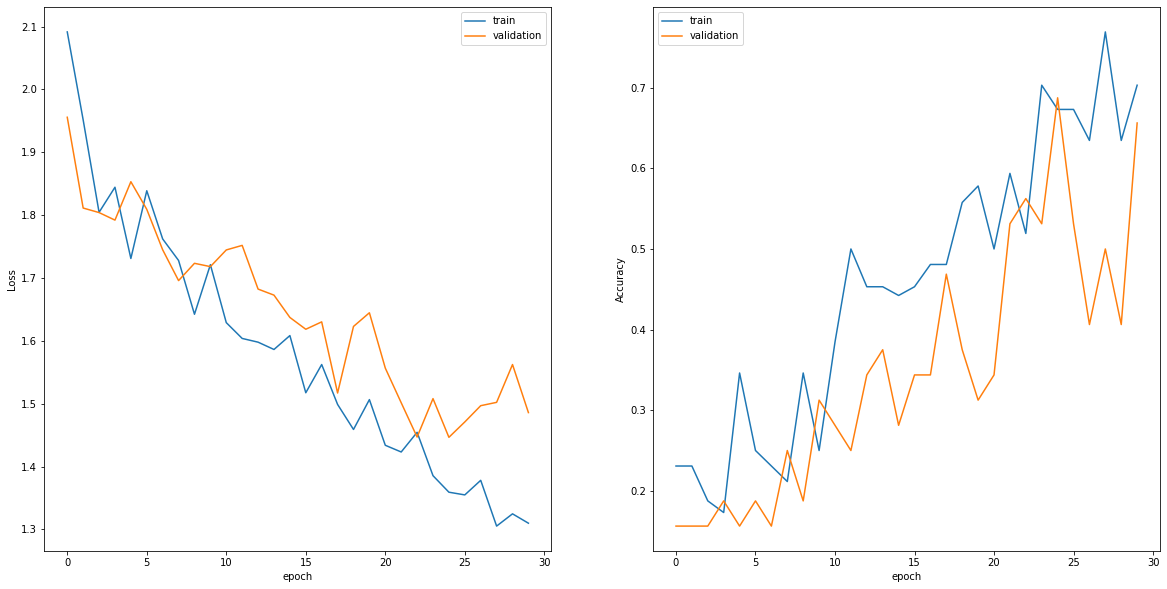

In [ ]:
def visualize(r):
    plt.figure(figsize=(20, 10))
    plt.subplot(121)
    plt.plot(r.epoch, r.history['loss'], label='train')
    plt.plot(r.epoch, r.history['val_loss'], label='validation')
    plt.legend(loc='best')
    plt.xlabel('epoch')
    plt.ylabel('Loss')

    # accuracies
    plt.subplot(122)
    plt.plot(r.epoch, r.history['accuracy'], label='train')
    plt.plot(r.epoch, r.history['val_accuracy'], label='validation')
    plt.legend(loc='best')
    plt.xlabel('epoch')
    plt.ylabel('Accuracy')

    plt.savefig('Vgg-Dicom.png')
    plt.show()

visualize(r)

Evaluating the model

In [ ]:
# Evaluating the model
#val_loss, val_acc = model.evaluate(validation_generator)
#print('Test loss: {:2f} Test Accuracy: {:.2f}'.format(test_loss, test_acc))
from tensorflow.keras.models import load_model
from tensorflow.keras.applications.vgg19 import preprocess_input,decode_predictions
new_model = load_model('/content/drive/MyDrive/Vgg19/Dicom/Vgg_diacom.h5')

# Evaluating the model
#val_loss, val_acc = model.evaluate(validation_generator)
#print('Test loss: {:2f} Test Accuracy: {:.2f}'.format(test_loss, test_acc))

train_loss,train_acc = new_model.evaluate_generator(train_generator, steps=train_generator.samples//batch_size, verbose=1)
val_loss,val_acc = new_model.evaluate_generator(validation_generator, steps=validation_generator.samples//batch_size, verbose=1) 
print('Train: %.3f' % train_acc) 
print('Val: %.3f' % val_acc)

Testing the model

In [ ]:
#train_loss,train_acc = model.evaluate_generator(train_generator, steps=train_generator.samples//batch_size, verbose=1)
test_loss,test_acc = new_model.evaluate_generator(test_generator) 
#print('Train: %.3f' % train_acc) 
print('Test: %.3f' % test_acc)

##Confusion matrix

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:2001: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


Confusion Matrix
60


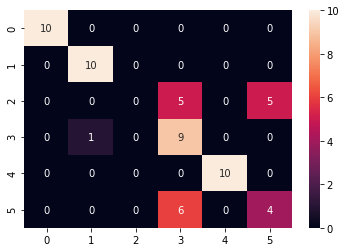

In [ ]:
# Confusion matrix
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
new_model = load_model('/content/drive/MyDrive/Vgg19/Dicom/Vgg_diacom.h5')
test_dir = '/content/drive/MyDrive/data/Test_Dicom'
Y_pred = new_model.predict_generator(test_generator)
y_pred = np.argmax(Y_pred, axis=1)
print('Confusion Matrix')
cm=confusion_matrix(test_generator.classes, y_pred)
print(cm.sum())
sns.heatmap(cm, annot=True)

In [ ]:
test_generator.class_indices

{'PD+T2_TSE_TRA_BRAI_000': 0,
 'T1-C_3D-SPACE_SAG_BRAI_000': 1,
 'T1_SE_COR_BRAI_000': 2,
 'T1_SE_TRA_BRAI_000': 3,
 'T2_3D-FLAIR_SAG_BRAI_000': 4,
 't2_tse_cor_HEAD21.02': 5}

In [ ]:
#Classification report
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
new_model = load_model('/content/drive/MyDrive/Vgg19/Dicom/Vgg_diacom.h5')
test_dir = '/content/drive/MyDrive/data/Test_Dicom'
Y_pred = new_model.predict_generator(test_generator)
y_pred = np.argmax(Y_pred, axis=1)
print(classification_report(test_generator.classes, y_pred))

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:2001: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


              precision    recall  f1-score   support

           0       1.00      1.00      1.00        10
           1       0.91      1.00      0.95        10
           2       0.00      0.00      0.00        10
           3       0.45      0.90      0.60        10
           4       1.00      1.00      1.00        10
           5       0.44      0.40      0.42        10

    accuracy                           0.72        60
   macro avg       0.63      0.72      0.66        60
weighted avg       0.63      0.72      0.66        60



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
best_model_path = '/content/drive/MyDrive/Vgg19/Dicom/Vgg_diacom.h5'
best_model = load_model(best_model_path)

embedding_layer = best_model.layers[-3]
extractor = Model(best_model.input, embedding_layer.output)
extractor.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg19_input (InputLayer)     [(None, 224, 224, 3)]     0         
_________________________________________________________________
vgg19 (Functional)           (None, 7, 7, 512)         20024384  
_________________________________________________________________
flatten_7 (Flatten)          (None, 25088)             0         
Total params: 20,024,384
Trainable params: 0
Non-trainable params: 20,024,384
_________________________________________________________________


In [ ]:
def prepare_img(image_path, width=224, height=224):
    """
    """
    img = img_to_array(load_img(image_path))
    img = cv2.resize(img, (width, height))
    img = img.astype('float32') / 255.
    return img


def get_feature(model, image):
    """
    """
    image = np.expand_dims(image, 0)
    return model.predict(image)


def calculate_similarity(vector1, vector2):
    return 1 - spatial.distance.cosine(vector1, vector2)


image_dir = '/content/drive/MyDrive/data/database3'
image_paths = glob.glob(os.path.join(image_dir, '*', '*'))


image1 = prepare_img(image_paths[0])
image2 = prepare_img(image_paths[50])

emb1 = get_feature(extractor, image1)
emb2 = get_feature(extractor, image2)

sim = calculate_similarity(emb1, emb2)
print('Similarity: %.6f' % sim)

Similarity: 0.873650


In [ ]:
#Code for similarity list for all in the database against a query image
all_sims = []

query_image = prepare_img('/content/drive/MyDrive/data/Dicom_test.jpg')

for val2 in range(len(image_paths)-1):
    image1 = query_image
    image2 = prepare_img(image_paths[val2])

    emb1 = get_feature(extractor, image1)
    emb2 = get_feature(extractor, image2)

    sim = calculate_similarity(emb1, emb2)
    # print (val2,sim)
 
    all_sims.append(sim)

In [ ]:
image_paths[0].split("/")[-1]

'01_Head_Brain(BRAI)_PD+T2_TSE_TRA_BRAI_000_2.jpg'

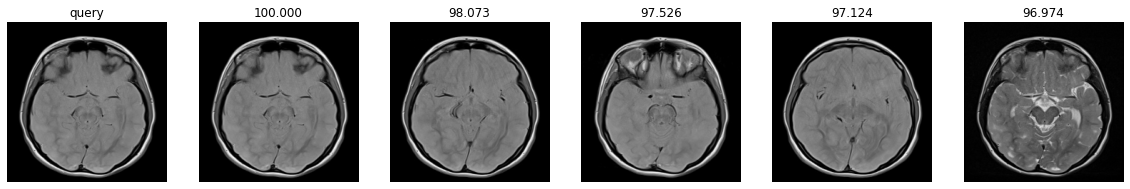

In [ ]:
n=5
top_n_loc = sorted(range(len(all_sims)), key=lambda k: all_sims[k], reverse = True)

top_scores=[]
for item in top_n_loc:
  top_scores.append(all_sims[item])

# print(len(top_n_loc), len(top_scores))

_,axes = plt.subplots(1, n+1, figsize=(20, 20))

axes[0].imshow(query_image)
axes[0].axis('off')
axes[0].set_title('query')
for i in range(n):
  axes[i+1].imshow(prepare_img(image_paths[top_n_loc[i]]))
  axes[i+1].set_title('%.3f' % (top_scores[i]*100))
  axes[i+1].axis('off')


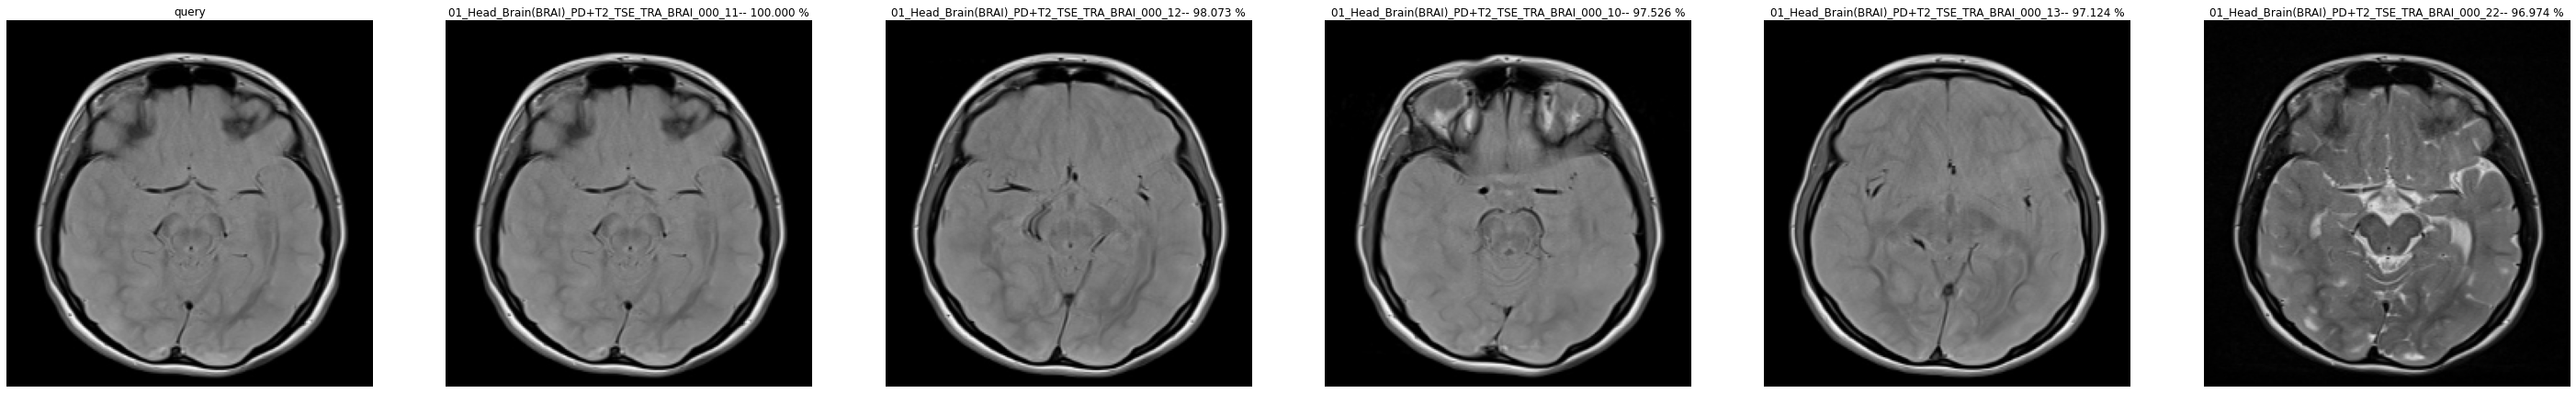

In [ ]:
n=5
top_n_loc = sorted(range(len(all_sims)), key=lambda k: all_sims[k], reverse = True)

top_scores=[]
for item in top_n_loc:
  top_scores.append(all_sims[item])

# print(len(top_n_loc), len(top_scores))

_,axes = plt.subplots(1, n+1, figsize=(20, 50))

axes[0].imshow(query_image)
axes[0].axis('off')
axes[0].set_title('query')
for i in range(n):
  axes[i+1].imshow(prepare_img(image_paths[top_n_loc[i]]))
  titlex=str(image_paths[top_n_loc[i]].split("/")[-1].split(".")[0]+"-- "+'%.3f' % (top_scores[i]*100)+" %")
  axes[i+1].set_title(titlex)
  axes[i+1].axis('off')

plt.show()